In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import timedelta

In [3]:
plt.style.use('Solarize_Light2')

In [57]:
rhpi = pd.read_csv('rhpi.csv',encoding="utf-16",sep='\t')

In [62]:
rhpi[rhpi['Region Type'] == 'Metro']['Region Name'].unique()

array(['Anaheim, CA', 'Atlanta, GA', 'Austin, TX', 'Baltimore, MD',
       'Boston, MA', 'Charlotte, NC', 'Chicago, IL', 'Cincinnati, OH',
       'Cleveland, OH', 'Columbus, OH', 'Dallas, TX', 'Denver, CO',
       'Detroit, MI', 'Fort Lauderdale, FL', 'Fort Worth, TX',
       'Houston, TX', 'Indianapolis, IN', 'Jacksonville, FL',
       'Kansas City, MO', 'Las Vegas, NV', 'Los Angeles, CA', 'Miami, FL',
       'Milwaukee, WI', 'Minneapolis, MN', 'Montgomery County, PA',
       'Nashville, TN', 'Nassau County, NY', 'New Brunswick, NJ',
       'New York, NY', 'Newark, NJ', 'Oakland, CA', 'Orlando, FL',
       'Philadelphia, PA', 'Phoenix, AZ', 'Pittsburgh, PA',
       'Portland, OR', 'Providence, RI', 'Riverside, CA',
       'Sacramento, CA', 'San Antonio, TX', 'San Diego, CA',
       'San Francisco, CA', 'San Jose, CA', 'Seattle, WA',
       'St. Louis, MO', 'Tampa, FL', 'Virginia Beach, VA', 'Warren, MI',
       'Washington, DC', 'West Palm Beach, FL'], dtype=object)

In [451]:
rhpi

,Region Type,"Month, Year of Date",Region Name,Redfin HPI MoM,Redfin HPI YoY
0,Metro,May 2024,"Anaheim, CA",0.58%,12.29%
1,Metro,May 2024,"Atlanta, GA",-0.13%,6.13%
2,Metro,May 2024,"Austin, TX",-0.65%,-0.51%
3,Metro,May 2024,"Baltimore, MD",-0.36%,6.20%
4,Metro,May 2024,"Boston, MA",-0.43%,9.70%
...,...,...,...,...,...
7594,US,May 2012,National,0.63%,NaN
7595,US,April 2012,National,0.72%,NaN
7596,US,March 2012,National,NaN,NaN
7597,US,February 2012,National,NaN,NaN


In [361]:
la_rhpi = rhpi[rhpi['Region Name'] == "Los Angeles, CA"][['Month, Year of Date','Redfin HPI MoM']]

In [362]:
la_rhpi['Month, Year of Date'] = pd.to_datetime(la_rhpi['Month, Year of Date'])
la_rhpi.rename(columns={'Month, Year of Date':'Date'},inplace=True)

In [363]:
la_rhpi.sort_values('Date',inplace=True)

In [364]:
la_rhpi.set_index('Date',inplace=True)


In [365]:
la_rhpi['Redfin HPI MoM'] = la_rhpi['Redfin HPI MoM'].apply(lambda x:float(str(x).replace('%','')))

In [366]:
la_rhpi = la_rhpi['Redfin HPI MoM']

In [368]:
la_rhpi = la_rhpi.asfreq(pd.infer_freq(la_rhpi.index))

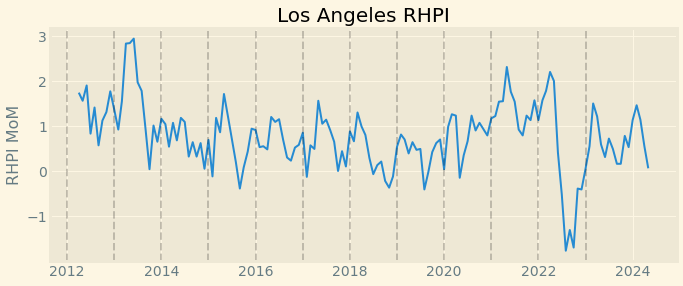

In [369]:
plt.figure(figsize=(10,4))
plt.plot(la_rhpi)
plt.title('Los Angeles RHPI', fontsize=20)
plt.ylabel('RHPI MoM', fontsize=16)
for year in range(2012,2024):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

### Normalize Time Series

In [370]:
mean, std = la_rhpi.mean(),la_rhpi.std()

In [371]:
la_rhpi = (la_rhpi - mean)/std

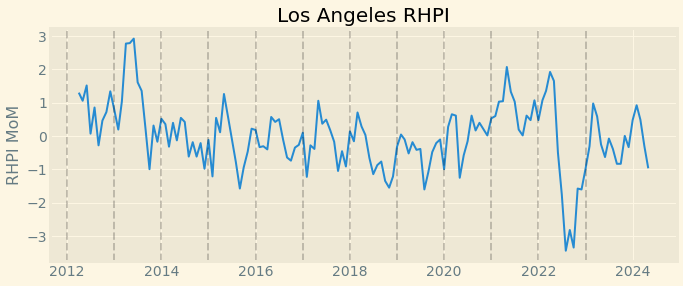

In [372]:
plt.figure(figsize=(10,4))
plt.plot(la_rhpi)
plt.title('Los Angeles RHPI', fontsize=20)
plt.ylabel('RHPI MoM', fontsize=16)
for year in range(2012,2024):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

### Take First Difference to Remove Trend

In [373]:
la_rhpi = la_rhpi.diff().dropna()

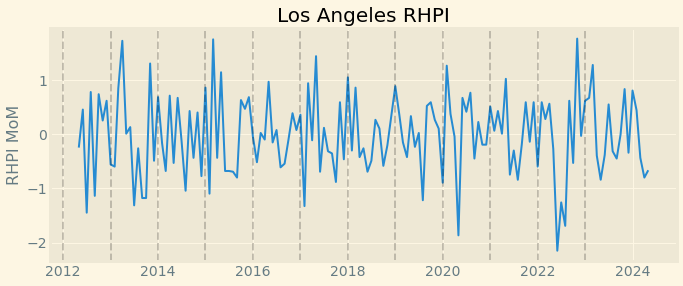

In [374]:
plt.figure(figsize=(10,4))
plt.plot(la_rhpi)
plt.title('Los Angeles RHPI', fontsize=20)
plt.ylabel('RHPI MoM', fontsize=16)
for year in range(2012,2024):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

### Remove Seasonality (Not Required SKIP)

In [256]:
month_avgs = la_rhpi.groupby(la_rhpi.index.month).mean()

In [257]:
la_rhpi_avg = la_rhpi.index.map(lambda x:month_avgs.loc[x.month])

In [258]:
la_rhpi = la_rhpi - la_rhpi_avg

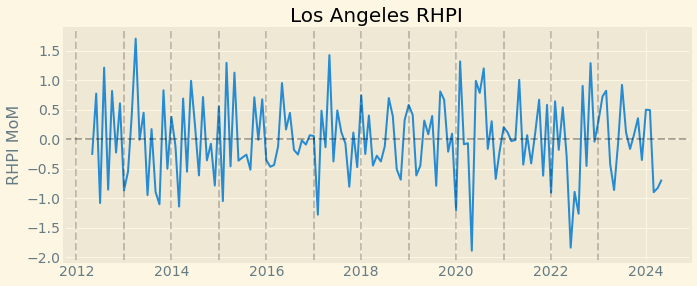

In [259]:
plt.figure(figsize=(10,4))
plt.plot(la_rhpi)
plt.title('Los Angeles RHPI', fontsize=20)
plt.ylabel('RHPI MoM', fontsize=16)
for year in range(2012,2024):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, linestyle='--', color='k', alpha=0.3)

### ACF and PACF

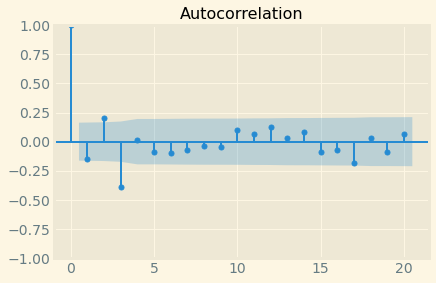

In [376]:
plot_acf(la_rhpi, lags=20);

/Users/chetanmunugala/anaconda3/envs/datasci/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


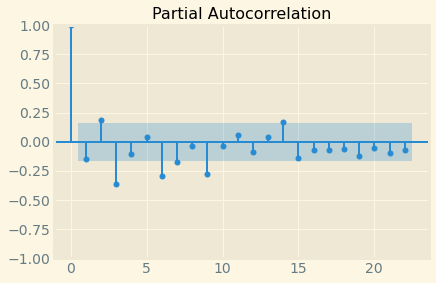

In [377]:
plot_pacf(la_rhpi);

### Based on the ACF, we consider starting adding an MA(3) component. Based on the PACF, we consider adding AR 3,6,and 9 components

### Test for Stationarity

Here we implement the augmented dickey fuller test. 



In [378]:
test_result = adfuller(la_rhpi)

In [379]:
print('ADF Statistic: %f' % test_result[0])
print('p-value: %f' % test_result[1])


ADF Statistic: -7.234555
p-value: 0.000000


Based on the ADF Test, we find that our series is stationary and suitable for modeling.

### ARMA Model

In [380]:
train_cutoff= round(len(la_rhpi) * 0.7)
val_cutoff= round(len(la_rhpi) * 0.85)
test_cutoff= len(la_rhpi)

In [381]:
train_data = la_rhpi[:train_cutoff]
val_data = la_rhpi[train_cutoff:val_cutoff]
test_data = la_rhpi[val_cutoff:test_cutoff]

In [397]:
model = ARIMA(train_data, order=(3,0,3))

In [398]:
fitted_model = model.fit()

/Users/chetanmunugala/anaconda3/envs/datasci/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [399]:
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:         Redfin HPI MoM   No. Observations:                  102
Model:                 ARIMA(3, 0, 3)   Log Likelihood                 -83.958
Date:                Tue, 06 Aug 2024   AIC                            183.917
Time:                        15:56:49   BIC                            204.916
Sample:                    05-01-2012   HQIC                           192.420
                         - 10-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0126      0.010     -1.270      0.204      -0.032       0.007
ar.L1         -0.3016      0.122     -2.467      0.014      -0.541      -0.062
ar.L2          0.0274      0.127      0.215      0.8

In [400]:
#get prediction start and end dates
pred_start_date = val_data.index[0]
pred_end_date = val_data.index[-1]

In [401]:
#get the predictions and residuals
predictions = fitted_model.predict(start=pred_start_date, end=pred_end_date)
residuals = val_data - predictions

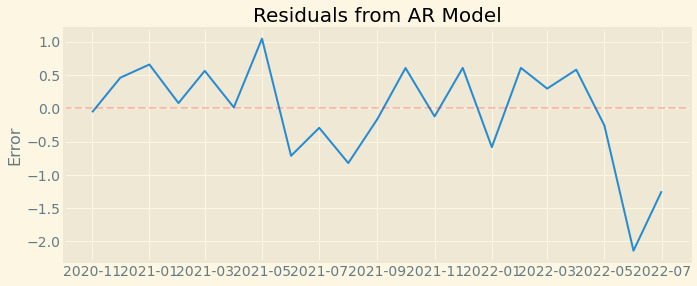

In [402]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Sales')

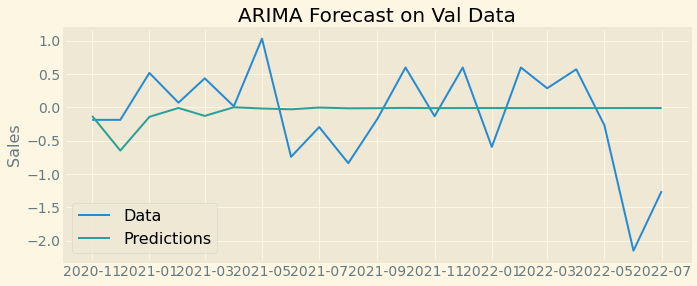

In [406]:
plt.figure(figsize=(10,4))

plt.plot(val_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('ARIMA Forecast on Val Data', fontsize=20)
plt.ylabel('Sales', fontsize=16)

### Rolling Forecast Origin

In [420]:
rolling_predictions = val_data.copy()
for train_end in val_data.index:
    train_data = la_rhpi[:train_end-timedelta(days=1)]
    model = ARIMA(train_data, order=(9,0,3))
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

/Users/chetanmunugala/anaconda3/envs/datasci/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chetanmunugala/anaconda3/envs/datasci/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chetanmunugala/anaconda3/envs/datasci/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/chetanmunugala/anaconda3/envs/datasci/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

In [424]:
rolling_residuals = val_data - rolling_predictions

Text(0, 0.5, 'Error')

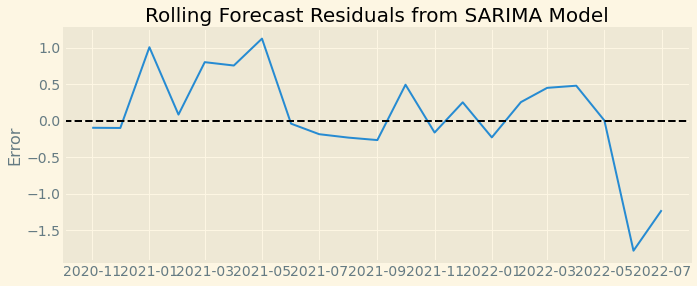

In [425]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

Text(0, 0.5, 'Sales')

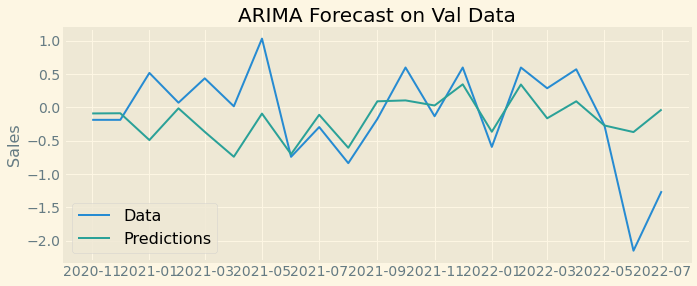

In [426]:
plt.figure(figsize=(10,4))

plt.plot(val_data)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('ARIMA Forecast on Val Data', fontsize=20)
plt.ylabel('Sales', fontsize=16)

In [448]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/val_data)),4))


Mean Absolute Percent Error: 3.4766


In [449]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 0.6626739679278899
